In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
x_test.shape

(10000, 32, 32, 3)

In [ ]:
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
# Convert labels to one-hot encoded format
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(x_train)


In [ ]:
# Load the ResNet50 model without the top layers and freeze its layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False  # Freeze the base model




94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Add custom layers
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


In [ ]:
from tensorflow.keras.optimizers import Adam
# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks for learning rate scheduling and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



In [ ]:
# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=50,
                    validation_data=(x_test, y_test), callbacks=[reduce_lr, early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 66ms/step - accuracy: 0.1739 - loss: 2.3017 - val_accuracy: 0.3565 - val_loss: 1.8687 - learning_rate: 1.0000e-04
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 54ms/step - accuracy: 0.2470 - loss: 2.0778 - val_accuracy: 0.3714 - val_loss: 1.8395 - learning_rate: 1.0000e-04
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.2651 - loss: 2.0364 - val_accuracy: 0.3761 - val_loss: 1.8169 - learning_rate: 1.0000e-04
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.2759 - loss: 2.0041 - val_accuracy: 0.3796 - val_loss: 1.8029 - learning_rate: 1.0000e-04
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.2784 - loss: 1.9945 - val_accuracy: 0.3870 - val_loss: 1.7884 - learning_rate: 1.0000e-04
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.2859 - loss: 1.9795 - val_accuracy: 0.3860 - val_loss: 1.7783 - learning_rate: 1.0000e-04
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 51ms/step - accurac

In [ ]:
# Save the model
model.save('model_name.h5')

In [ ]:
# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fine-tune the model
history_fine = model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=30,
                         validation_data=(x_test, y_test),callbacks=[reduce_lr, early_stopping])


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 132s 100ms/step - accuracy: 0.1412 - loss: 3.4917 - val_accuracy: 0.1238 - val_loss: 4.2903 - learning_rate: 1.0000e-05
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 93s 66ms/step - accuracy: 0.2353 - loss: 2.5482 - val_accuracy: 0.3582 - val_loss: 1.7889 - learning_rate: 1.0000e-05
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.2854 - loss: 2.2141 - val_accuracy: 0.4148 - val_loss: 1.6271 - learning_rate: 1.0000e-05
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.3363 - loss: 1.9791 - val_accuracy: 0.4591 - val_loss: 1.4920 - learning_rate: 1.0000e-05
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.3775 - loss: 1.8060 - val_accuracy: 0.4991 - val_loss: 1.3800 - learning_rate: 1.0000e-05
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - accuracy: 0.4162 - loss: 1.6797 - val_accuracy: 0.5286 - val_loss: 1.2949 - learning_rate: 1.0000e-05
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 62ms/step - accur

In [ ]:

# Generate predictions and classification report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred_classes))



In [ ]:

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

In [ ]:

# Evaluate the fine-tuned model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Fine-tuned Model Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.1006 - loss: 3.6680
Fine-tuned Model Test Accuracy: 0.1000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


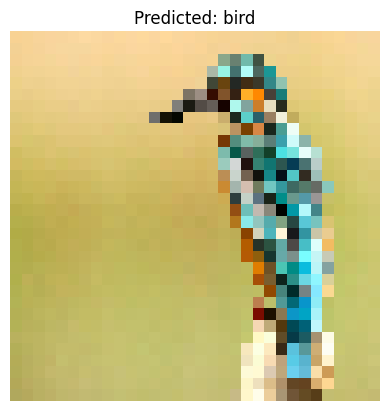

In [ ]:
# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(32, 32))  # Resize to 32x32 pixels
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize pixel values
    return img, img_array

# Function to make a prediction
def predict_image(img_path, model):
    # Load and preprocess the image
    img, img_array = load_and_preprocess_image(img_path)

    # Make a prediction
    predictions = model.predict(img_array)

    # Get the index of the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)

    # Mapping of CIFAR-10 class indices to human-readable labels
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    # Get the class name
    predicted_label = class_names[predicted_class[0]]

    # Display the image with the prediction label
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')  # Hide the axes
    plt.show()


img_path = 'bird.jpg'
predict_image(img_path, model)


In [ ]:
from tensorflow.keras.preprocessing import image

def load_display_and_preprocess_image(img_path):

    original_img = image.load_img(img_path)

    # Resize the image to 32x32 pixels for prediction
    img = image.load_img(img_path, target_size=(32, 32))
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize pixel values

    return original_img, img_array

In [ ]:
# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    original_img = image.load_img(img_path)

    img = image.load_img(img_path, target_size=(32, 32))  # Resize to 32x32 pixels
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize pixel values
    return img, img_array

In [ ]:
def predict_and_display(img_path, model):
    original_img, img_array = load_display_and_preprocess_image(img_path)
    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    # Get the class name
    predicted_label = class_names[predicted_class[0]]
    # Display the original image with the prediction label
    plt.imshow(original_img)
    plt.title(f"Predicted: {predicted_label}")
    plt.show()

In [ ]:
img_path = 'bird.jpg'
predict_image(img_path, model)